# Ejercicios 

1. Maximizar la función f(x) = x sen(10 π x) + 1, con x ∈ [0,1].

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from random import randint, uniform
import random
import pandas as pd
from PIL import Image


In [8]:
# Parámetros del AG
L = 8  # Longitud del cromosoma (bits)
K = 100  # Tamaño de la población
M = 100  # Número de generaciones
p_mut = 0.05  # Probabilidad de mutación
elite_size = 2  # Número de mejores individuos que se conservan cada generación

# Función objetivo
def f(x):
    return x * np.sin(10 * np.pi * x) + 1

# Decodificación binaria → real en [0, 1]
def decode(crom):
    decimal = sum([bit * 2**(L - 1 - i) for i, bit in enumerate(crom)])
    return decimal / (2**L - 1)

# Generar población inicial
def generar_poblacion():
    return [[randint(0, 1) for _ in range(L)] for _ in range(K)]

# Evaluar aptitud
def evaluar(poblacion):
    aptitudes = [f(decode(ind)) for ind in poblacion]
    total = sum(aptitudes)
    probabilidades = [a / total for a in aptitudes]
    return aptitudes, probabilidades

# Selección por ruleta
def seleccionar(poblacion, probabilidades):
    nueva_poblacion = []
    for _ in range(K - elite_size):  # Reducir la población en 1 para elitismo
        r = uniform(0, 1)
        suma = 0
        for i, p in enumerate(probabilidades):
            suma += p
            if r <= suma:
                nueva_poblacion.append(poblacion[i][:])
                break
    return nueva_poblacion

# Cruce en un punto
def cruzar(poblacion):
    hijos = []
    # Asegurarse de que la población sea par
    if len(poblacion) % 2 != 0:
        poblacion.pop()  # Eliminar el último individuo si es impar

    for i in range(0, len(poblacion), 2):  # Asegurarse de tener parejas
        padre1 = poblacion[i]
        padre2 = poblacion[i + 1]
        punto = randint(1, L - 1)
        hijo1 = padre1[:punto] + padre2[punto:]
        hijo2 = padre2[:punto] + padre1[punto:]
        hijos.extend([hijo1, hijo2])
    return hijos

# Mutación
def mutar(poblacion):
    for ind in poblacion:
        for i in range(L):
            if uniform(0, 1) < p_mut:
                ind[i] = 1 - ind[i]
    return poblacion

Mejor x encontrado: 0.8509803921568627
f(x) máxima encontrada: 1.8505767889325506


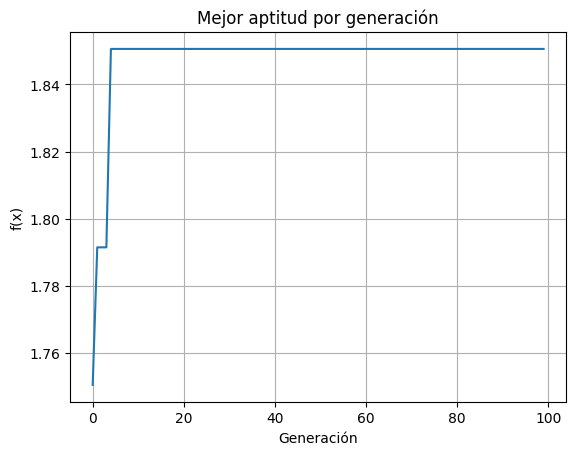

In [9]:
# Algoritmo Genético
poblacion = generar_poblacion()
mejores = []

for _ in range(M):
    aptitudes, probabilidades = evaluar(poblacion)
    mejores.append(max(aptitudes))
    
    # Elitismo: conservar los mejores N individuos
    elite = sorted(zip(poblacion, aptitudes), key=lambda x: x[1], reverse=True)[:elite_size]
    elite_individuals = [ind for ind, _ in elite]
    
    seleccionados = seleccionar(poblacion, probabilidades)
    hijos = cruzar(seleccionados)
    poblacion = mutar(hijos)

    # Mantener los mejores individuos
    poblacion = elite_individuals + poblacion[:K - elite_size]  # Mantener los mejores

# Resultados
aptitudes_finales, _ = evaluar(poblacion)
mejor_ind = poblacion[np.argmax(aptitudes_finales)]
mejor_x = decode(mejor_ind)
mejor_f = f(mejor_x)

# Mostrar resultados
print(f"Mejor x encontrado: {mejor_x}")
print(f"f(x) máxima encontrada: {mejor_f}")

# Gráfico de convergencia
plt.plot(mejores)
plt.title("Mejor aptitud por generación")
plt.xlabel("Generación")
plt.ylabel("f(x)")
plt.grid(True)
plt.show()

2. Verdadera democracia. Suponga que usted es el jefe de gobierno y está interesado en que pasen
los proyectos de su programa político. Sin embargo, en el congreso conformado por 5 partidos, no
es fácil su tránsito, por lo que debe repartir el poder, conformado por ministerios y otras agencias
del gobierno, con base en la representación de cada partido. Cada entidad estatal tiene un peso de
poder, que es el que se debe distribuir. Suponga que hay 50 curules, distribuya aleatoriamente, con
una distribución no informe entre los 5 partidos esas curules. Defina una lista de 50 entidades y
asígneles aleatoriamente un peso político de 1 a 100 puntos. Cree una matriz de poder para repartir
ese poder, usando AGs.

In [13]:

# 5 partidos políticos
partidos = ['A', 'B', 'C', 'D', 'E']
curules_total = 50

# Distribución no uniforme de curules
curules = np.random.multinomial(curules_total, [0.4, 0.25, 0.2, 0.1, 0.05])
representacion = dict(zip(partidos, curules))
print("Representación por partido:", representacion)

entidades = [f"Entidad_{i+1}" for i in range(50)]
pesos_entidades = [random.randint(1, 100) for _ in range(50)]
print("Ejemplo de entidades con pesos:", list(zip(entidades[:5], pesos_entidades[:5])))

def crear_cromosoma(representacion):
    cromosoma = []
    for i, partido in enumerate(partidos):
        cromosoma += [partido] * representacion[partido]
    random.shuffle(cromosoma)
    return cromosoma

def fitness(cromosoma, pesos, representacion):
    poder_por_partido = {p: 0 for p in partidos}
    for idx, partido in enumerate(cromosoma):
        poder_por_partido[partido] += pesos[idx]

    poder_total = sum(pesos)
    ideal = {p: (representacion[p]/curules_total) * poder_total for p in partidos}
    
    error = sum(abs(poder_por_partido[p] - ideal[p]) for p in partidos)
    return -error  # Entre menor el error, mejor el fitness

def mutar(cromosoma):
    i, j = random.sample(range(len(cromosoma)), 2)
    cromosoma[i], cromosoma[j] = cromosoma[j], cromosoma[i]
    return cromosoma

def cruzar(padre, madre):
    punto = random.randint(1, len(padre) - 2)
    hijo = padre[:punto] + madre[punto:]
    return hijo

def algoritmo_genetico(pesos, representacion, generaciones=100, poblacion_size=50):
    poblacion = [crear_cromosoma(representacion) for _ in range(poblacion_size)]

    for _ in range(generaciones):
        poblacion.sort(key=lambda c: fitness(c, pesos, representacion), reverse=True)
        nueva_poblacion = poblacion[:10]  # elitismo

        while len(nueva_poblacion) < poblacion_size:
            padre, madre = random.sample(poblacion[:25], 2)
            hijo = cruzar(padre.copy(), madre.copy())
            if random.random() < 0.2:
                hijo = mutar(hijo)
            nueva_poblacion.append(hijo)
        poblacion = nueva_poblacion
    
    mejor = max(poblacion, key=lambda c: fitness(c, pesos, representacion))
    return mejor

# Crear una distribución y pesos
pesos = [random.randint(1, 100) for _ in range(50)]
representacion = dict(zip(partidos, np.random.multinomial(50, [0.4, 0.25, 0.2, 0.1, 0.05])))

# Ejecutar AG
asignacion_optima = algoritmo_genetico(pesos, representacion)

# Resultados
asignaciones = {p: 0 for p in partidos}
poder_partido = {p: 0 for p in partidos}
for idx, partido in enumerate(asignacion_optima):
    asignaciones[partido] += 1
    poder_partido[partido] += pesos[idx]

print("\nDistribución final de entidades por partido:", asignaciones)
print("Poder total recibido por partido:", poder_partido)


Representación por partido: {'A': 17, 'B': 12, 'C': 14, 'D': 5, 'E': 2}
Ejemplo de entidades con pesos: [('Entidad_1', 77), ('Entidad_2', 76), ('Entidad_3', 81), ('Entidad_4', 63), ('Entidad_5', 77)]

Distribución final de entidades por partido: {'A': 19, 'B': 14, 'C': 11, 'D': 4, 'E': 2}
Poder total recibido por partido: {'A': 840, 'B': 692, 'C': 594, 'D': 247, 'E': 99}


3. Una empresa proveedora de energía eléctrica dispone de cuatro plantas de generación para
satisfacer la demanda diaria de energía eléctrica en Cali, Bogotá, Medellín y Barranquilla. Cada una
puede generar 3, 6, 5 y 4 GW al día respectivamente. Las necesidades de Cali, Bogotá, Medellín y
Barranquilla son de 4, 3, 5 y 3 GW al día respectivamente. Los costos por el transporte de energía
por cada GW entre plantas y ciudades se dan en la siguiente tabla:

![Tabla1](Images\Tabla_1.png)

Los costos del KW-H por generador se dan en la siguiente tabla:

![Tabla1](Images\Tabla_1.png)

Encontrar usando AGs el mejor despacho de energía minimizando los costos de transporte y
generación.

In [16]:
# Datos del problema
generacion = [3, 6, 5, 4]  # Capacidad de cada planta en GW (Planta C, B1, M, B2)
demanda = [4, 3, 5, 3]     # Demanda por ciudad en GW (Cali, Bogotá, Medellín, Barranquilla)

# Costos de transporte por GW
transporte = np.array([
    [1, 4, 3, 6],  # Planta C
    [4, 1, 4, 5],  # Planta B1
    [3, 4, 1, 4],  # Planta M
    [6, 5, 4, 1]   # Planta B2
])

# Costo de generación en millones de pesos por GW
generacion_costo = np.array([680, 720, 660, 750])

# Parámetros del algoritmo genético
num_individuos = 100
num_generaciones = 100
prob_mutacion = 0.3

# Función para generar un individuo válido (matriz 4x4)
def generar_individuo():
    individuo = np.zeros((4, 4))
    for i in range(4):
        disponible = generacion[i]
        proporciones = np.random.dirichlet(np.ones(4))  # distribución proporcional
        valores = proporciones * disponible
        individuo[i] = np.round(valores, 2)
    return individuo

# Función de evaluación: retorna costo total (generación + transporte + penalización)
def evaluar(individuo):
    costo = 0.0
    for i in range(4):
        for j in range(4):
            energia = individuo[i][j]
            costo += energia * (generacion_costo[i] + transporte[i][j] * 1e6)

    penalizacion = 0.0
    for i in range(4):
        exceso = individuo[i].sum() - generacion[i]
        if exceso > 0:
            penalizacion += exceso * 1e9
    for j in range(4):
        deficit = demanda[j] - individuo[:, j].sum()
        if deficit > 0:
            penalizacion += deficit * 1e9

    return costo + penalizacion

# Cruce entre dos individuos (mezcla por filas)
def cruzar(ind1, ind2):
    hijo = np.zeros((4, 4))
    for i in range(4):
        hijo[i] = ind1[i] if random.random() < 0.5 else ind2[i]
    return hijo

# Mutación: cambia aleatoriamente una fila de energía
def mutar(individuo):
    nuevo = individuo.copy()
    for i in range(4):
        if random.random() < prob_mutacion:
            proporciones = np.random.dirichlet(np.ones(4))
            valores = proporciones * generacion[i]
            nuevo[i] = np.round(valores, 2)
    return nuevo

# Inicialización de la población
poblacion = [generar_individuo() for _ in range(num_individuos)]

# Evolución
for gen in range(num_generaciones):
    evaluaciones = [(evaluar(ind), ind) for ind in poblacion]
    evaluaciones.sort(key=lambda x: x[0])
    nueva_poblacion = [evaluaciones[i][1] for i in range(10)]  # elitismo

    while len(nueva_poblacion) < num_individuos:
        padre1, padre2 = random.choices(evaluaciones[:50], k=2)
        hijo = cruzar(padre1[1], padre2[1])
        hijo = mutar(hijo)
        nueva_poblacion.append(hijo)

    poblacion = nueva_poblacion

# Resultado final
mejor = min(poblacion, key=evaluar)
costo_total = evaluar(mejor)

# Mostrar resultados
df_resultado = pd.DataFrame(
    mejor,
    index=["Planta C", "Planta B1", "Planta M", "Planta B2"],
    columns=["Cali", "Bogotá", "Medellín", "Barranquilla"]
)

print("Despacho óptimo de energía (en GW):")
print(df_resultado)
print(f"\nCosto total mínimo: ${costo_total:,.2f}")

Despacho óptimo de energía (en GW):
           Cali  Bogotá  Medellín  Barranquilla
Planta C   2.37    0.60      0.03          0.00
Planta B1  0.59    3.36      1.74          0.31
Planta M   1.68    0.11      3.18          0.03
Planta B2  0.12    0.26      0.11          3.51

Costo total mínimo: $33,852,660.00
